# SVD recommendation model

SVD decomposition takes user-item matrix of `m x n` size and splits into three parts:
$$U_{m x k} \times \sum_{k x k} \times V_{k x n}^T$$
- $U_{m x k} =$ user (row) and latent factors k (col)
- $\sum_{k x k} =$ latent factors k. I.e., the weights
    - Latent factor k is the number of factors or features to consider for the model
- $V_{k x n}^T =$ transpose matrix of item (row) x latent factors k (col)
- Too low of k leads to a simple model (underfitting), too high of k leads to a complex model (overfitting)


Error metrics:
- MAE: More easier to interpret than RMSE, but less sensitive to outliers
- RMSE: computes the square root of the average of the squared differences between the predicted rating and the actual ratings 
$$ RMSE = \sqrt{\frac{1}{N}\sum_{(u,i) \in R} (r_{ui} - \hat{r_{ui}})^2}$$


The 3 main hyper parameters to tune for SVD are:
1. Latent factor $k$
2. Regularization parameter $\lambda$
    - $J = \text{new cost} = \sum_{(u, i) \in R}[(r_{ui} - \hat{r_{ui}})^2 + \lambda (\sum_u || P_u ||^2 + \sum_i || Q_i ||^2)]$
    - $P =$ vector of latent factors for user u
    - $Q =$ vector of latent factors for user k
Larger value -> more penalization
If value too large -> underfit, If value too small -> overfit
3. Learning rate $\alpha$
    - If too high, then model may overshoot minimum thus failing to converge
    - If too low, then model may take too long to converge / stuck at local minimum
    - The gradients are derived from the cost functions
        - $P_u \leftarrow P_u + \alpha * [(r_{ui} - \hat{r_{ui}})^2 Q_i - \lambda P_u]$
        - $Q_i \leftarrow Q_i + \alpha * [(r_{ui} - \hat{r_{ui}})^2 P_u - \lambda Q_i]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Import datasets

In [2]:
data = pd.read_csv('./datasets/merged.csv')
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code,title,genres
0,4958,1407,5,2003-02-28 12:47:23,M,18,7,55403,Scream (1996),Horror|Thriller
1,5950,1407,2,2000-05-01 07:50:46,M,25,4,19713,Scream (1996),Horror|Thriller
2,4607,1407,3,2000-07-21 12:25:04,M,25,0,27403,Scream (1996),Horror|Thriller
3,5312,1407,5,2000-06-29 14:31:32,M,25,1,10463,Scream (1996),Horror|Thriller
4,3391,1407,4,2000-08-30 11:45:55,M,18,4,48135,Scream (1996),Horror|Thriller


In [3]:
trainset = pd.read_csv('./datasets/train.csv')
trainset.head()

,user_id,movie_id,rating
0,4168,3082,3
1,4284,2763,4
2,798,2559,5
3,4345,2529,3
4,984,3099,4


In [4]:
testset = pd.read_csv('./datasets/test.csv')
testset.head()

,user_id,movie_id,rating
0,5412,2431,5
1,5440,111,5
2,368,2976,3
3,425,2139,4
4,4942,2532,3


## Build SVD model

In [11]:
from surprise import SVD, Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split 

# trainset, testset = train_test_split(data[['user_id', 'movie_id', 'rating']], test_size = 0.01, random_state = 42)

reader = Reader(rating_scale = (1, 5))
train_data = Dataset.load_from_df(trainset, reader)
train_data = train_data.build_full_trainset()

test_data = list(testset.itertuples(index = False, name = None))

# As explained above, we will only focus on three hyper parameters
    # number of factors (n_factors), learning rate (lr_all), and regularization parameter (reg_all)
    # default for number of epochs is 20
hyperparameters = [
    {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.01}, 
    {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}, # default
    {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.03}, 
    {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}, 
    {'n_factors': 250, 'n_epochs': 20, 'lr_all': 0.012, 'reg_all': 0.08}, 
    {'n_factors': 300, 'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.1}, 
    {'n_factors': 350, 'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.12}, 
]

res = []
for params in hyperparameters:
    # Create an SVD model
    svd_model = SVD(
        n_factors=params['n_factors'],
        n_epochs=params['n_epochs'],
        lr_all=params['lr_all'],
        reg_all=params['reg_all']
    )
    
    # Train the model on the training data
    svd_model.fit(train_data)
    
    # Predict on the training set (to evaluate training RMSE)
    train_predictions = svd_model.test(train_data.build_testset())
    train_rmse = accuracy.rmse(train_predictions, verbose=False)
    
    # Predict on the test set (to evaluate validation RMSE)
    test_predictions = svd_model.test(test_data)
    test_rmse = accuracy.rmse(test_predictions, verbose=False)
    
    # Display results
    print(f"For parameters {params}")
    print(f"\tTraining RMSE: {train_rmse:.4f}")
    print(f"\tValidation RMSE: {test_rmse:.4f}")
    res.append({'parameters': params, 'training_rmse': train_rmse, 'test_rmse': test_rmse})

For parameters {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.01}
	Training RMSE: 0.8448
	Validation RMSE: 0.9454
For parameters {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
	Training RMSE: 0.6706
	Validation RMSE: 0.9218
For parameters {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.03}
	Training RMSE: 0.5908
	Validation RMSE: 0.9210
For parameters {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}
	Training RMSE: 0.6755
	Validation RMSE: 0.9084
For parameters {'n_factors': 250, 'n_epochs': 20, 'lr_all': 0.012, 'reg_all': 0.08}
	Training RMSE: 0.7951
	Validation RMSE: 0.9225
For parameters {'n_factors': 300, 'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.1}
	Training RMSE: 0.8348
	Validation RMSE: 0.9375
For parameters {'n_factors': 350, 'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.12}
	Training RMSE: 0.8611
	Validation RMSE: 0.9474


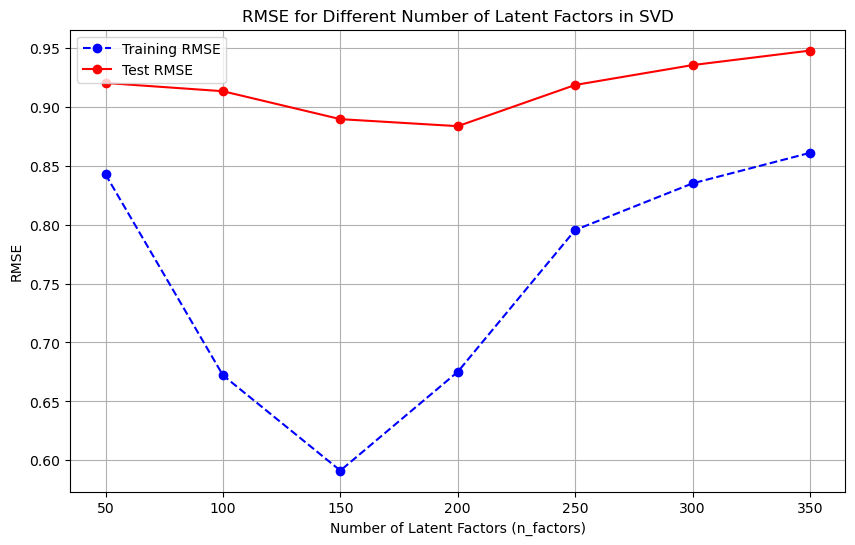

In [10]:
import matplotlib.pyplot as plt
# Extract RMSE values for plotting
n_factors = [params['n_factors'] for params in hyperparameters]
train_rmse_values = [r['training_rmse'] for r in res]
test_rmse_values = [r['test_rmse'] for r in res]

# Plot RMSE values for different n_factors
plt.figure(figsize=(10, 6))
plt.plot(n_factors, train_rmse_values, label="Training RMSE", marker='o', linestyle='--', color='b')
plt.plot(n_factors, test_rmse_values, label="Test RMSE", marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Number of Latent Factors (n_factors)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Number of Latent Factors in SVD')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

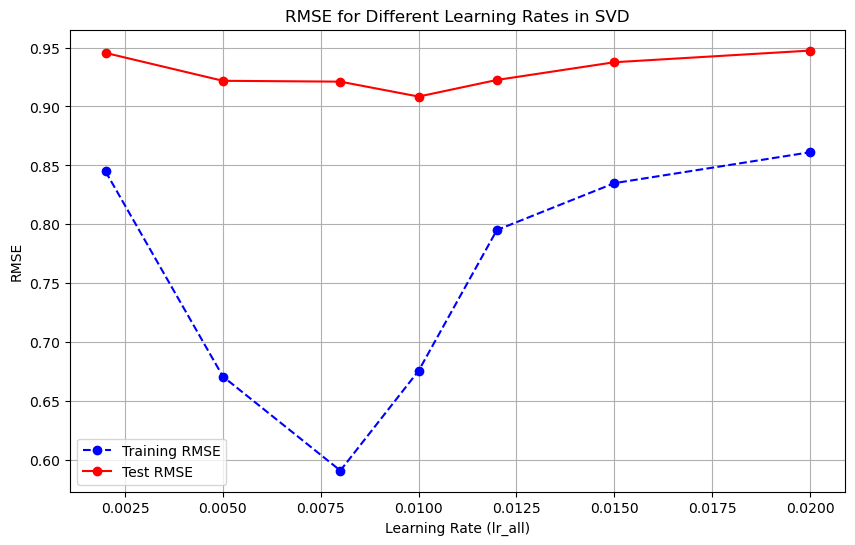

In [14]:
# Extract lr_all values for plotting
lr_all_values = [params['lr_all'] for params in hyperparameters]
train_rmse_values_lr = [r['training_rmse'] for r in res]
test_rmse_values_lr = [r['test_rmse'] for r in res]

# Plot RMSE values for different learning rates (lr_all)
plt.figure(figsize=(10, 6))
plt.plot(lr_all_values, train_rmse_values_lr, label="Training RMSE", marker='o', linestyle='--', color='b')
plt.plot(lr_all_values, test_rmse_values_lr, label="Test RMSE", marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Learning Rate (lr_all)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Learning Rates in SVD')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

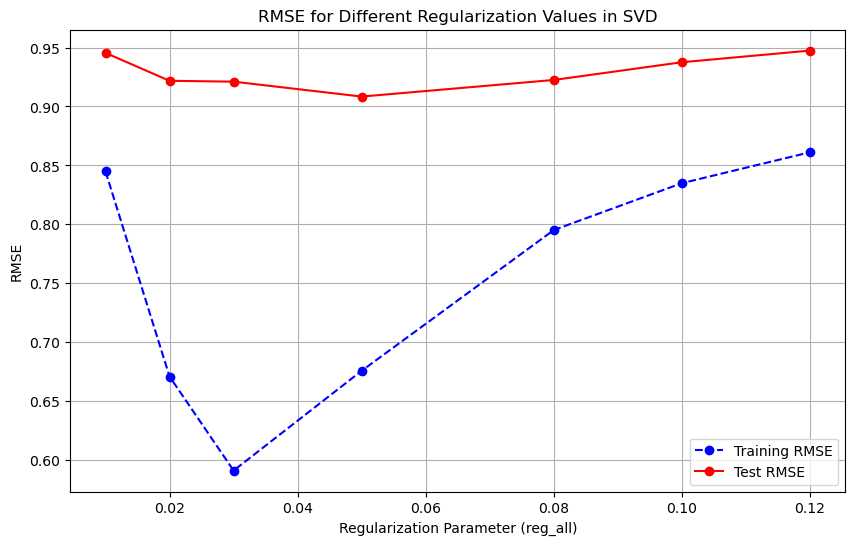

In [15]:
# Extract reg_all values for plotting
reg_all_values = [params['reg_all'] for params in hyperparameters]
train_rmse_values_reg = [r['training_rmse'] for r in res]
test_rmse_values_reg = [r['test_rmse'] for r in res]

# Plot RMSE values for different regularization values (reg_all)
plt.figure(figsize=(10, 6))
plt.plot(reg_all_values, train_rmse_values_reg, label="Training RMSE", marker='o', linestyle='--', color='b')
plt.plot(reg_all_values, test_rmse_values_reg, label="Test RMSE", marker='o', linestyle='-', color='r')

# Adding labels and title
plt.xlabel('Regularization Parameter (reg_all)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Regularization Values in SVD')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [19]:
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code,title,genres
0,4958,1407,5,2003-02-28 12:47:23,M,18,7,55403,Scream (1996),Horror|Thriller
1,5950,1407,2,2000-05-01 07:50:46,M,25,4,19713,Scream (1996),Horror|Thriller
2,4607,1407,3,2000-07-21 12:25:04,M,25,0,27403,Scream (1996),Horror|Thriller
3,5312,1407,5,2000-06-29 14:31:32,M,25,1,10463,Scream (1996),Horror|Thriller
4,3391,1407,4,2000-08-30 11:45:55,M,18,4,48135,Scream (1996),Horror|Thriller


In [28]:
# Optimal range for different parameters:
# n_params = [100, 250]
# lr_all = [0.005, 0.010]
# reg_all = [0.02, 0.08]

from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV

# Define the hyperparameters grid to search
param_grid = {
    'n_factors': [100, 150, 200, 250],       
    'n_epochs': [20],               
    'lr_all': [0.005, 0.007, 0.009, 0.011],        
    'reg_all': [0.02, 0.05, 0.08]           
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    SVD, 
    param_grid, 
    measures = ['rmse', 'mae'], 
    cv = 3,
    n_jobs = -2 # use all cpu except for 1  
    # joblib_verbose = 3
)

# Fit the data
# The GridSearchCV automatically split dataset into train & test, so we need to provide full data
reader = Reader(rating_scale = (1, 5))
full_data = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader)
grid_search.fit(full_data)

# Get the best RMSE score and the corresponding hyperparameters
print(f"Best RMSE score: {grid_search.best_score['rmse']}")
print(f"Best hyperparameters: {grid_search.best_params['rmse']}")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  3.6min


Best RMSE score: 0.8644578813409264
Best hyperparameters: {'n_factors': 250, 'n_epochs': 20, 'lr_all': 0.011, 'reg_all': 0.05}


[Parallel(n_jobs=-2)]: Done 144 out of 144 | elapsed:  4.7min finished


In [ ]:
best_svd_model = SVD(
    n_factors=200,
    n_epochs=50,
    lr_all=0.005,
    reg_all=0.1
)

# Train the model on the training data
best_svd_model.fit(train_data)

# Predict on the test set (to evaluate validation RMSE)
test_predictions = best_svd_model.test(test_data)
test_rmse = accuracy.rmse(test_predictions, verbose=False)

# Display results
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {test_rmse:.4f}")

# Get an estimation for 
best_svd_model.predict(196, 302).est

In [27]:
# Export model
import pickle
with open('./models/svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)